In [1]:
import pandas as pd
import numpy as np
import os.path as op
import seaborn as sns
import pingouin
import matplotlib.pyplot as plt

source_folder = '/Users/mrenke/data/ds-dnumrisk/derivatives/phenotype'

df_participants = pd.read_csv(op.join('/Users/mrenke/data/ds-dnumrisk/add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
df_participants = df_participants.loc[:,['subject ID', 'age','group','gender']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
df_participants['group'] = np.where(df_participants['group'] == 0, 'control', 'dyscalc')


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
#magjudge_probit_params = pd.read_csv(op.join(source_folder,'probit-2_all-subwise-params.csv')).set_index('subject')
magjudge_probit_params = pd.read_csv(op.join(source_folder,'probit-2_all-subwise-params_appropSample.csv')).set_index('subject')
magjudge_probit_params.rename(columns={'gamma':'gamma_magjudge', 'intercept':'intercept_magjudge'},inplace=True)


In [6]:
model_label =3 # 1 n1_evidence_sd & n2_evidence_sd, 3 = memory_noise_sd & perceptual_noise_sd
magjudge_bauer_params = pd.read_csv(op.join(source_folder,f'magjudge_bauer-{model_label}_sds.csv')).set_index('subject')
#magjudge_bauer_params.head()

In [5]:
rnps = pd.read_csv(op.join(source_folder, 'rnp_sub-format-wise.csv'))
df_rnp = rnps.set_index(['subject', 'format']).unstack('format')
df_rnp = df_rnp.droplevel(0, axis=1, ).rename(columns={'non-symbolic': 'rnp_nonsymb','symbolic': 'rnp_symb'})


In [6]:
math_stuff = pd.read_csv(op.join(source_folder, 'math_skill&confidence&anxiety-means.csv')).set_index('subject')
decode = pd.read_csv(op.join(source_folder, 'decoding_r.csv')).set_index('subject')

In [7]:
vs_wm = pd.read_csv(op.join(source_folder, 'visio-spatial-WM_CBTtask-params.csv'))
vs_wm.set_index('subject', inplace=True)

In [4]:
# risk symbolic: SS (stake size) RNP slope
ss_rnp_slope =  pd.read_csv(op.join(source_folder,f'risk_SS-RNP-subwise-MAPs_probit-2_format-symbolic.csv'))
ss_rnp_slope = ss_rnp_slope.set_index('subject').rename(columns={'slope':'ss_rnp_slope'})[['ss_rnp_slope']]

In [21]:
# eyetracking (only smybolic format)
format = 'non-symbolic'  # 'symbolic' or 'non-symbolic'
eyetrack_dur_diff = pd.read_csv(op.join(source_folder, f'subwise_duration_option_difference_abs_{format}.tsv')).set_index('subject')


In [9]:
# risk probit params
gammas_symbolic = pd.read_csv(op.join(source_folder, f'probit_model-2_format-symbolic_gammas.csv'))
gammas_symbolic = gammas_symbolic.set_index('subject').drop(columns=['Unnamed: 0'])
gammas_nonsymbolic = pd.read_csv(op.join(source_folder, f'probit_model-2_format-non-symbolic_gammas.csv'))
gammas_nonsymbolic = gammas_nonsymbolic.set_index('subject').drop(columns=['Unnamed: 0'])
risk_gammas = gammas_symbolic.join(gammas_nonsymbolic, lsuffix='_symbolic', rsuffix='_nonsymbolic')
risk_gammas['gamma_mean'] = risk_gammas.mean(axis=1)
#gammas.head()

In [ ]:
panamath_scores = pd.read_csv('/Users/mrenke/data/ds-dnumrisk/add_tables/panamath_AllRunsSummary.csv')

df_pana = panamath_scores.rename(mapper={'Subject ID': 'subject'}, axis=1).set_index('subject')[['Number of Trials','Weber Fraction', 'Percent Correct', 'Number of Non-RT-Outlier Trials']]
df_pana.rename(mapper={'Weber Fraction': 'weber_frac'}, inplace=True, axis=1)
df_pana.drop(999, axis=0, inplace=True)
df_pana.sort_index(inplace=True)
print(len(df_pana))
#df_pana.head() #    = 64
#df_pana[['weber_frac', 'Percent Correct']].to_csv(op.join(source_folder, 'ANSacuity_panamath.csv'))

66


/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### combine them

In [22]:
df_comb = magjudge_bauer_params.join(eyetrack_dur_diff).join(ss_rnp_slope)

In [11]:
df_comb = magjudge_bauer_params.join(df_pana['weber_frac']).join(vs_wm)
df_comb['weber_transformed'] = np.log(df_comb['weber_frac'])
df_comb['group'] = np.where(df_comb['group'] == 0, 'control', 'dyscalc')

In [17]:
df_comb = magjudge_probit_params.join(math_stuff).join(decode)#.join(df_pana['weber_frac']).join(risk_gammas).join(df_participants).join(vs_wm)
df_comb['intercept_magjudge_abs'] = df_comb['intercept_magjudge'].abs()

In [55]:
df_comb = df_rnp.join(math_stuff).join(decode).join(df_pana['weber_frac']).join(gammas).join(df_participants)
df_comb['rnp_symb_dif'] = np.abs(df_comb['rnp_symb'] - 0.55)
df_comb['rnp_nonsymb_dif'] = np.abs(df_comb['rnp_nonsymb'] - 0.55)

In [61]:
df_comb = magjudge_bauer_params.join(df_rnp).join(gammas).join(df_pana['weber_frac']).join(vs_wm['erfassungsspanne']).join(math_stuff)

In [23]:
df_comb = magjudge_bauer_params.join(magjudge_probit_params).join(decode).join(ss_rnp_slope)
df_comb['mag_noise_ratio'] = df_comb['memory_noise_sd'] / df_comb['perceptual_noise_sd']

In [17]:
df_comb.head()

,memory_noise_sd,perceptual_noise_sd,group,subject\tduration_option_difference_abs,ss_rnp_slope
subject,,,,,
1,0.128094,0.074870,0,2\t103.02127659574468,0.004826
2,0.222981,0.052561,1,3\t18.93193717277487,0.018223
3,0.137517,0.160089,0,4\t49.59375,0.014621
4,0.178991,0.021833,1,5\t2.7807486631016043,0.012692
5,0.130870,0.126985,0,6\t124.39252336448598,0.011311


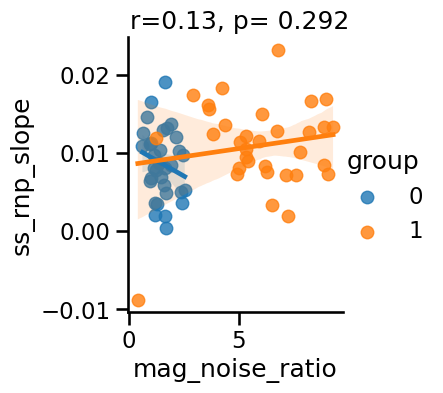

In [62]:
sns.set_context('talk')

y_var = 'ss_rnp_slope' #'skill_score' # '4c' # 4b' #
x_var = 'mag_noise_ratio'#'gamma_nonsymbolic' # 'conf_mean'
cor = pingouin.corr(df_comb[y_var], df_comb[x_var], method = 'shepherd') #defautl: two -sided & pearson 
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

fig = sns.lmplot(x=x_var, y=y_var, data=df_comb, hue='group',height=4) #, hue='group'
fig.set(title=f' r={r_}, p= {p}' )  #ylabel='Anxiety', xlabel='Skill', 


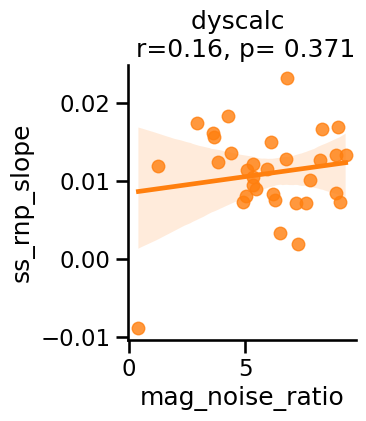

In [64]:
group = 1
tmp = df_comb[df_comb['group'] == group]

cor = pingouin.corr(tmp[y_var], tmp[x_var]) #, method = 'shepherd') #defautl: two -sided & pearson 
r_ = np.round(cor['r'][0], 2)
p = np.round(cor['p-val'][0], 3)

color = sns.color_palette()[group]
fig = sns.lmplot(x=x_var, y=y_var, data=tmp,height=4,scatter_kws={'color': color}, line_kws={'color': color})
group_name = 'control' if group == 0 else 'dyscalc'
fig.set(title=f'{group_name} \n r={r_}, p= {p}' ) 

In [13]:
vars

Index(['memory_noise_sd', 'perceptual_noise_sd',
       'subject\tduration_option_difference_abs', 'ss_rnp_slope'],
      dtype='object')

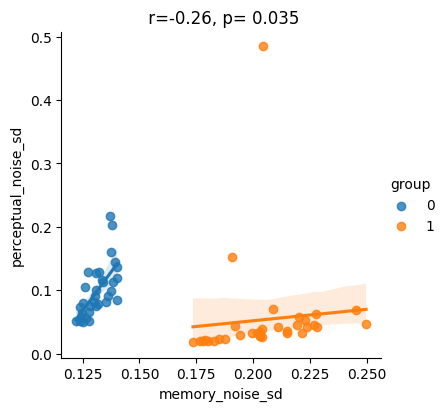

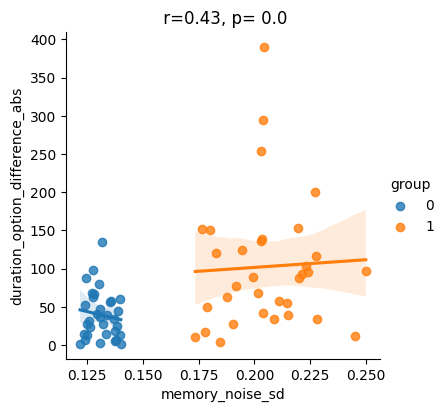

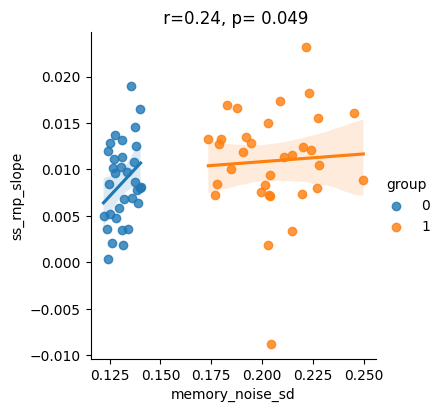

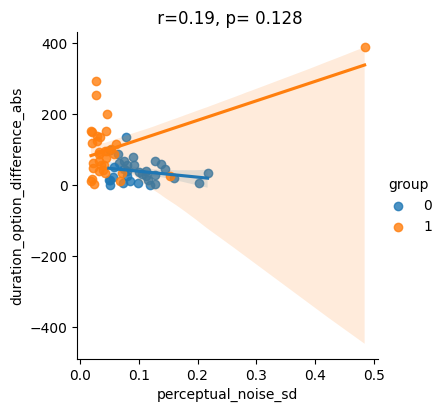

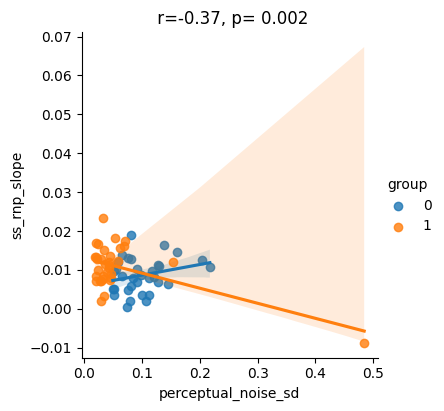

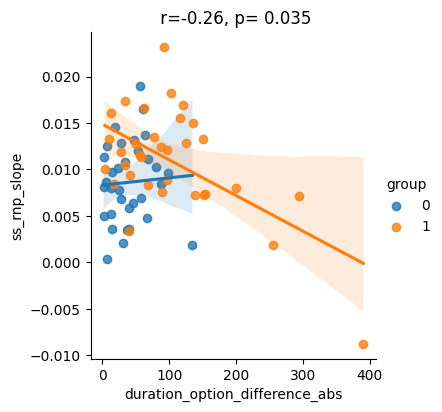

In [23]:
# correlate all variables in the dataframe
import itertools
  
#vars = df_comb.columns.drop(['group','gender'])
vars = df_comb.columns.drop(['group'])

for x_var, y_var in itertools.combinations(vars, 2):
    cor = pingouin.corr(df_comb[y_var], df_comb[x_var])
    r_ = np.round(cor['r'][0], 2)
    p = np.round(cor['p-val'][0], 3)
    #print(f'{x_var} vs {y_var}: r={r_}, p= {p}')
    fig = sns.lmplot(x=x_var, y=y_var, data=df_comb, hue='group',height=4) #, hue='group' hue='group',
    fig.set(title=f' r={r_}, p= {p}') 

In [ ]:
# groups separately

colors = [sns.color_palette()[0], sns.color_palette()[1]]

for x_var, y_var in itertools.combinations(vars, 2):
    fig,ax = plt.subplots(1,2, figsize=(8,3))

    for i,group in enumerate(df_comb['group'].unique()):
        cor = pingouin.corr(df_comb.loc[df_comb['group'] == group, y_var], df_comb.loc[df_comb['group'] == group, x_var])
        r_ = np.round(cor['r'][0], 2)
        p = np.round(cor['p-val'][0], 3)
        
        sns.regplot(x=x_var, y=y_var, data=df_comb[df_comb['group'] == group], ax=ax[i], color=colors[i])
        ax[i].set(title=f'{group}, r={r_}, p={p}', ylabel=y_var, xlabel=x_var)
        sns.despine()

    plt.subplots_adjust(wspace=0.5)

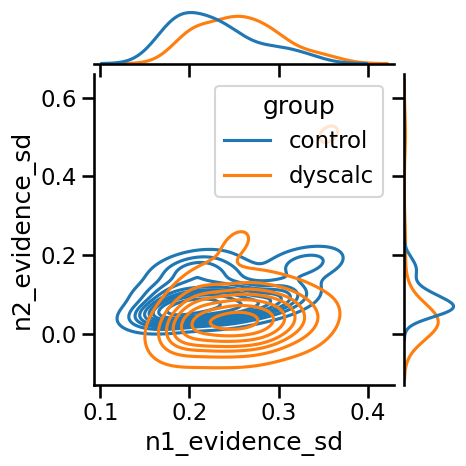

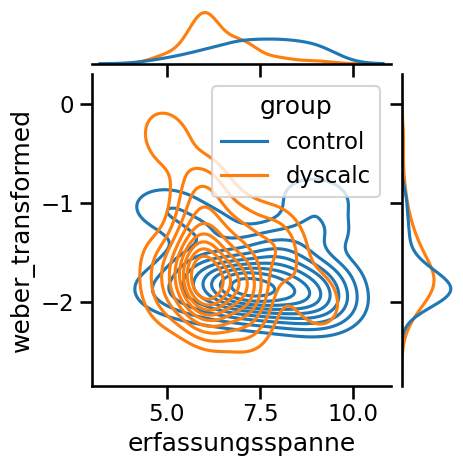

In [102]:
x_var = 'n1_evidence_sd' #'memory_noise_sd'
y_var = 'n2_evidence_sd' #'perceptual_noise_sd'
sns.jointplot(x=x_var, y=y_var, data=df_comb, kind='kde', hue='group',height=5)   
sns.jointplot(x='erfassungsspanne', y='weber_transformed', data=df_comb, kind='kde', hue='group',height=5)   


[Text(0.5, 1.0, 'p=0.015'), (0.1, 0.4)]

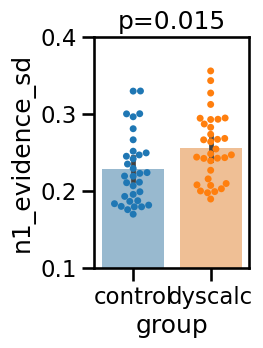

In [45]:
y_var = 'n1_evidence_sd' 

fig, ax = plt.subplots(figsize=(2,3))
sns.barplot(ax=ax,data=df_comb.reset_index(), x='group', y=y_var, hue='group',alpha=0.5)
sns.swarmplot(ax=ax, data=df_comb.reset_index(), x='group', y=y_var,  hue='group',size=5)

an = pingouin.anova(data=df_comb.reset_index(), dv=y_var, between='group')
p_val = np.round(an['p-unc'][0],3)
ax.set(title=f'p={p_val}',ylim=(0.1,0.4),)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 51.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/mrenke/mambaforge/envs/behav_fit/lib/python3.10/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of th

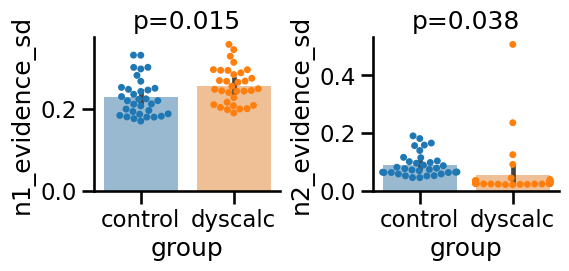

In [42]:
import pingouin as pg

df_param = df_comb

fig, ax = plt.subplots(1,2, figsize=(6,2))
for i,y_var in enumerate(['n1_evidence_sd', 'n2_evidence_sd']): 
    sns.barplot(ax=ax[i],data=df_param.reset_index(), x='group', y=y_var, hue='group',alpha=0.5)
    sns.swarmplot(ax=ax[i], data=df_param.reset_index(), x='group', y=y_var,  hue='group',size=5)
    an = pg.anova(data=df_param.reset_index(), dv=y_var, between='group')
    p_val = np.round(an['p-unc'][0],3)

    ax[i].set(title=f'p={p_val}') # ylim=(0.,0.4),
    ax[i].legend().remove()
    sns.despine()
plt.subplots_adjust(wspace=0.5)


# test slope difference

In [4]:
df_comb = math_stuff.join(gammas).join(df_participants)
print(df_comb.index.unique())

df_comb.head()

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
            18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
            35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
            52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66],
           dtype='int64', name='subject')


,skill_score,anx_mean,conf_mean,gamma_symbolic,gamma_nonsymbolic,gamma_mean,age,group,gender
subject,,,,,,,,,
1,36.0,1.333333,2.666667,4.144728,2.316990,3.230859,19.0,0,w
2,6.0,2.666667,0.666667,0.804526,1.447929,1.126228,17.0,1,w
3,29.0,1.666667,3.333333,1.013945,1.074758,1.044351,15.0,0,w
4,34.0,4.000000,1.833333,1.937536,2.418975,2.178255,17.0,1,w
5,30.0,2.000000,2.333333,2.407660,1.819713,2.113687,20.0,0,w


In [15]:
import bambi

ind_var = 'gamma_symbolic'
formula = f'skill_score ~ {ind_var}*group' # + age + gender'

model = bambi.Model(formula, data=df_comb.reset_index())
results = model.fit(draws=5000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Intercept, gamma_symbolic, group, gamma_symbolic:group, skill_score_sigma]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 13 seconds.


0.8736


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,33.358,4.617,24.601,41.837,0.067,0.047,4730.0,6323.0,1.0
gamma_symbolic,-0.030,1.584,-3.103,2.878,0.023,0.016,4626.0,5748.0,1.0
group,-20.862,6.111,-31.852,-8.807,0.099,0.070,3847.0,4606.0,1.0
gamma_symbolic:group,2.850,2.497,-1.828,7.579,0.040,0.028,3900.0,5248.0,1.0
skill_score_sigma,9.340,0.843,7.767,10.899,0.011,0.008,6242.0,6448.0,1.0


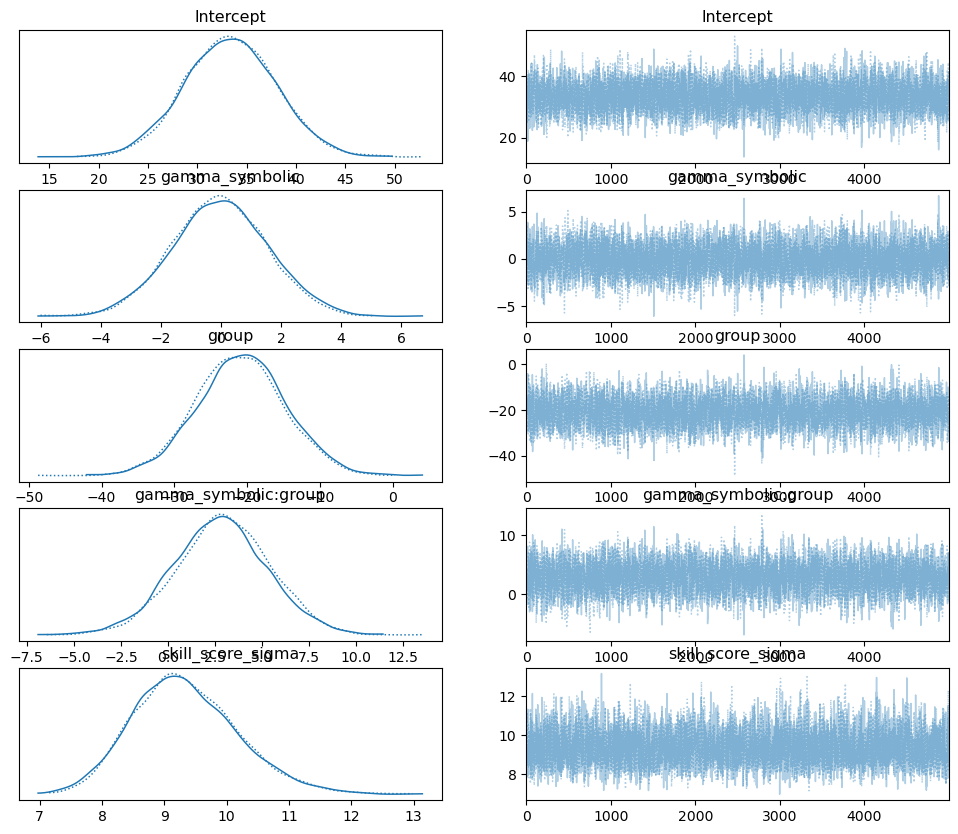

In [16]:
import arviz as az

p_val_int  = np.mean(results.posterior[f'{ind_var}:group'].to_dataframe().values > 0)
print(p_val_int)
az.plot_trace(results)
az.summary(results)